In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = "/content/drive/MyDrive/CZ4042 NNDL/" # path to Google Drive, for colab
resnet_ft = os.path.join(path, "model_ft")
resnet50_ft = os.path.join(path, "org_transfer.h5")

In [3]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.0 MB/s 


In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, resnet50
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [5]:
batch_size = 128
n_workers = 12
image_size = 224
train_set = Flowers102(
    root="./data",
    split = 'train',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=n_workers,
    pin_memory=True,
    shuffle=True,
)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting data/flowers-102/102flowers.tgz to data/flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
n_way = 5
n_shot = 6
n_query = 4
n_validation_tasks = 100

val_set = Flowers102(
    root="./data",
    split = 'val',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
val_set.get_labels = lambda: [
    instance[1] for instance in val_set
]
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

In [7]:
n_way = 5
n_shot = 4
n_query = 6
n_test_tasks = 200

test_set = Flowers102(
    root="./data",
    split = 'test',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
         transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)
test_set.get_labels = lambda: [
    instance[1] for instance in test_set
]
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks= n_test_tasks
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [8]:
class PrototypicalNetworksNormal(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworksNormal, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
      
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [9]:
# convolutional_network = resnet18(pretrained=True)
# convolutional_network.fc = nn.Flatten()

convolutional_network = resnet18(pretrained=False)
convolutional_network.fc.requires_grad = False
convolutional_network.load_state_dict(torch.load(resnet_ft))
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworksNormal(convolutional_network).cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

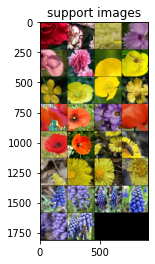

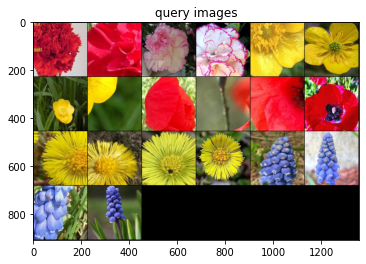

In [10]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(val_loader))

plot_images(example_support_images, "support images", images_per_row=n_shot)
plot_images(example_query_images, "query images", images_per_row=n_query)

In [12]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)


In [13]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )
    return (correct_predictions/total_predictions)


evaluate(test_loader)

100%|██████████| 200/200 [01:09<00:00,  2.89it/s]

Model tested on 200 tasks. Accuracy: 93.53%


0.9353333333333333

In [14]:
N_TRAINING_EPISODES = 500
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set]
train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Define Triplet Loss

In [15]:
import torch
import torch.nn as nn

def pairwise_distance_torch(embeddings, device):

    # pairwise distance matrix with precise embeddings
    precise_embeddings = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(precise_embeddings, 2).sum(axis=-1)
    c2 = torch.pow(precise_embeddings.transpose(0, 1), 2).sum(axis=0)
    c3 = precise_embeddings @ precise_embeddings.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    pairwise_distances_squared = c12 - 2.0 * c3

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = torch.max(pairwise_distances_squared, torch.tensor([0.]).to(device))
    # Get the mask where the zero distances are at.
    error_mask = pairwise_distances_squared.clone()
    error_mask[error_mask > 0.0] = 1.
    error_mask[error_mask <= 0.0] = 0.

    pairwise_distances = torch.mul(pairwise_distances_squared, error_mask)

    # Explicitly set diagonals to zero.
    mask_offdiagonals = torch.ones((pairwise_distances.shape[0], pairwise_distances.shape[1])) - torch.diag(torch.ones(pairwise_distances.shape[0]))
    pairwise_distances = torch.mul(pairwise_distances.to(device), mask_offdiagonals.to(device))
    return pairwise_distances

def TripletSemiHardLoss(y_true, y_pred, device, margin=1.0):
    labels, embeddings = y_true, y_pred

    # Reshape label tensor to [batch_size, 1].
    lshape = labels.shape
    labels = torch.reshape(labels, [lshape[0], 1])

    pdist_matrix = pairwise_distance_torch(embeddings, device)

    # Build pairwise binary adjacency matrix.
    adjacency = torch.eq(labels, labels.transpose(0, 1))
    # Invert so we can select negatives only.
    adjacency_not = adjacency.logical_not()

    batch_size = labels.shape[0]

    # Compute the mask.
    pdist_matrix_tile = pdist_matrix.repeat(batch_size, 1)
    adjacency_not_tile = adjacency_not.repeat(batch_size, 1)

    transpose_reshape = pdist_matrix.transpose(0, 1).reshape(-1, 1)
    greater = pdist_matrix_tile > transpose_reshape

    mask = adjacency_not_tile & greater

    # final mask
    mask_step = mask.to(dtype=torch.float32)
    mask_step = mask_step.sum(axis=1)
    mask_step = mask_step > 0.0
    mask_final = mask_step.reshape(batch_size, batch_size)
    mask_final = mask_final.transpose(0, 1)

    adjacency_not = adjacency_not.to(dtype=torch.float32)
    mask = mask.to(dtype=torch.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    axis_maximums = torch.max(pdist_matrix_tile, dim=1, keepdim=True)
    masked_minimums = torch.min(torch.mul(pdist_matrix_tile - axis_maximums[0], mask), dim=1, keepdim=True)[0] + axis_maximums[0]
    negatives_outside = masked_minimums.reshape([batch_size, batch_size])
    negatives_outside = negatives_outside.transpose(0, 1)

    # negatives_inside: largest D_an.
    axis_minimums = torch.min(pdist_matrix, dim=1, keepdim=True)
    masked_maximums = torch.max(torch.mul(pdist_matrix - axis_minimums[0], adjacency_not), dim=1, keepdim=True)[0] + axis_minimums[0]
    negatives_inside = masked_maximums.repeat(1, batch_size)

    semi_hard_negatives = torch.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = margin + pdist_matrix - semi_hard_negatives

    mask_positives = adjacency.to(dtype=torch.float32) - torch.diag(torch.ones(batch_size)).to(device)
    num_positives = mask_positives.sum()

    triplet_loss = (torch.max(torch.mul(loss_mat, mask_positives), torch.tensor([0.]).to(device))).sum() / num_positives
    triplet_loss = triplet_loss.to(dtype=embeddings.dtype)
    return triplet_loss


class TripletLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, input, target, **kwargs):
        return TripletSemiHardLoss(target, input, self.device)

In [17]:
criterion = TripletLoss(0)
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion
    a = loss.forward(classification_scores, query_labels.cuda())
    optimizer.step()
    return a.item()

In [18]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 500/500 [02:57<00:00,  2.82it/s, loss=0.0862]


In [19]:
evaluate(val_loader)

100%|██████████| 100/100 [00:33<00:00,  3.01it/s]

Model tested on 100 tasks. Accuracy: 95.30%


0.953

In [20]:
evaluate(test_loader)

100%|██████████| 200/200 [01:06<00:00,  3.01it/s]

Model tested on 200 tasks. Accuracy: 93.97%


0.9396666666666667